$\textbf{Sample code of value iteration algorithm (Algorithm 6.2 in [1]) and Hierarchical Supervised Learning (HSL) algorithm}$ $\textbf{(Algorithm 6.3 in [1]) to find Nash Equilibrium in constant sum, stochastic, } \textbf{Advanced Persistent Threats-Dynamic Information Flow}$ $\textbf{Tracking (APT-DIFT) games}$

$\textbf{Code Description:}$

(1) Python Version: 3.7

(2) Keras Version: 2.3.1

(3) This code takes as input Ransomeware_Data.mat file. Ransomeware_Data.mat is a data file containing state space of APT-DIFT game extracted from Ransomware [2] system logs.

(4) For detailed explanation of the value iteration algorithm and APT-DIFT game please refer to [1].

$\textbf{Note:}$ You may freely redistribute and use this sample code, with or without modification, provided you include the original Copyright notice and use restrictions.

$\textbf{Disclaimer:}$ THE SAMPLE CODE IS PROVIDED "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL DINUKA SAHABANDU OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) SUSTAINED BY YOU OR A THIRD PARTY, HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT ARISING IN ANY WAY OUT OF THE USE OF THIS SAMPLE CODE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
For additional information, contact:
Dinuka Sahabandu, email: sdinuka@uw.edu

$\textbf{Acknowledgement:}$ This work was supported by ONR grant N00014-16-1-2710 P00002, DARPA TC grant DARPA FA8650-15-C-7556, and ARO grant W911NF-16-1-0485.

[1] Shana Moothedath, Dinuka Sahabandu, Joey Allen, Linda Bushnell, Wenke Lee, and Radha Poovendran, “Stochastic Dynamic Information Flow Tracking Game using Supervised Learning for Detecting Advanced Persistent Threats".
     - Arxiv link: https://arxiv.org/pdf/2007.12327.pdf
     - Website: https://adapt.ece.uw.edu/
     
[2] Ji, Yang, Sangho Lee, Mattia Fazzini, Joey Allen, Evan Downing, Taesoo Kim, Alessandro Orso, and Wenke Lee. "Enabling refinable cross-host attack investigation with efficient data flow tagging and tracking." In 27th USENIX Security Symposium (USENIX Security 18), pp. 1705-1722. 2018.

In [1]:
import numpy as np
import networkx as nx
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from numpy.random import rand
from scipy.io import loadmat
from keras.models import load_model
import time

Using TensorFlow backend.


In [2]:
class trainingData:
    entry_points = None
    destination = None
    FN = None
    FP = None
    beta = None
    IFG = None
    SS = None
    Action_set_DIFT = None
    Action_set_APT = None
    intermediate_destinations = None


    def __init__(self,entry_points,destination,intermediate_destinations,FN,FP,beta,IFG,SS,Action_set_DIFT,Action_set_APT):
        self.entry_points = entry_points
        self.destination = destination
        self.FN = FN
        self.FP = FP
        self.beta = beta
        self.IFG = IFG
        self.SS = SS
        self.Action_set_DIFT = Action_set_DIFT
        self.Action_set_APT = Action_set_APT
        self.intermediate_destinations = intermediate_destinations

    def Generate_Training_Data(self,training_sets, pecent_stochastic_DIFT, pecent_stochastic_APT):
        IFG_length = len(self.IFG)
        SS_length = len(self.SS)

        DIFT_Policies_Data = []
        APT_Policies_Data = []
        
        V = np.zeros((training_sets, SS_length))
        V[:, IFG_length + 1] = self.beta
        V[:, IFG_length + 3] = self.beta

        Input_vector_NN = [] #Input to the NN (i.e., DIFT policy + APT policy corresponding to each time ts)
        Output_Data_NN = [] #Output of the NN (i.e., Value vector)
             
        
        for ts in range(0,training_sets):
            #seed(1)
            
            policy_type_DIFT = 0 #Type of DIFT policy :- Type 0: Deterministic, Type 1:Stochastic 
            uniform_var_DIFT = np.random.uniform(0,1,1)
            if pecent_stochastic_DIFT >= uniform_var_DIFT*100:
                policy_type_DIFT = 1
                
            #Generating random policies for DIFT
            DIFT_Policy = []
            
            if policy_type_DIFT == 0:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_DIFT[ii]) != 1:
                        random_vec_DIFT = np.zeros(len(self.Action_set_DIFT[ii]))
                        DIFT_action = np.random.randint(len(self.Action_set_DIFT[ii]), size=1)
                        random_vec_DIFT[DIFT_action] = 1
                        DIFT_Policy.append((random_vec_DIFT).tolist()) 
                    else:
                        DIFT_Policy.append([1])
            else:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_DIFT[ii]) != 1:
                        random_vec_DIFT = abs(rand(len(self.Action_set_DIFT[ii])))
                        DIFT_Policy.append((random_vec_DIFT / sum(random_vec_DIFT)).tolist())
                    else:
                        DIFT_Policy.append([1])
                        
            
            policy_type_APT = 0 #Type of APT policy :- Type 0: Deterministic, Type 1:Stochastic 
            uniform_var_APT = np.random.uniform(0,1,1)
            if pecent_stochastic_APT >= uniform_var_APT*100:
                policy_type_APT = 1
            
            
            # Generating random policies for APT
            APT_Policy = []
            
            if policy_type_APT == 0:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_APT[ii]) != 1:
                        random_vec_APT = np.zeros(len(self.Action_set_APT[ii]))
                        APT_action = np.random.randint(len(self.Action_set_APT[ii]), size=1)
                        random_vec_APT[APT_action] = 1
                        APT_Policy.append((random_vec_APT).tolist()) 
                    else:
                        APT_Policy.append([1])
            else:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_APT[ii]) != 1:
                        random_vec_APT = abs(rand(len(self.Action_set_APT[ii])))
                        APT_Policy.append((random_vec_APT / sum(random_vec_APT)).tolist())
                    else:
                        APT_Policy.append([1])
                    

            #Collect policy data into list
            DIFT_Policies_Data.append(DIFT_Policy)
            APT_Policies_Data.append(APT_Policy)

            #Evaluating the valuye functions (Dynamic programing:Back propagation approach to evaluate value function)

            #Convert IFG transition matrix to nx.DiGraph format
            IFG_graph = nx.DiGraph()
            for ii in range(IFG_length):
                for jj in range(IFG_length):
                    if self.IFG[ii, jj] == 1:
                        IFG_graph.add_edge(ii, jj)
            #Topological order for dynamic program (Only consider IFG node related states)
            TP_Order = list(reversed(list(nx.topological_sort(IFG_graph))))
            #Excluding destination node related states from state space
            SS_To_Visit = TP_Order.copy()
            for ii in range(0,len(TP_Order)):
                dest_flag = TP_Order[ii] in self.destination.tolist()
                inter_dest_flag = TP_Order[ii] in self.intermediate_destinations.tolist()
                if int(dest_flag) == 1 or int(inter_dest_flag) == 1:
                    pop_index = SS_To_Visit.index(TP_Order[ii])
                    SS_To_Visit.pop(pop_index)

            #Calculating the values at all non-absorbing states except at the virtual state
            #V[ts, SS_To_Visit[ii]] = 0
            for ii in range(0,len(SS_To_Visit)):
                for dd in range(0,len(self.Action_set_DIFT[SS_To_Visit[ii]])):
                    for aa in range(0,len(self.Action_set_APT[SS_To_Visit[ii]])):
                        if aa == (len(self.Action_set_APT[SS_To_Visit[ii]]) - 1):  # APT dropout
                            V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + V[ts, IFG_length + 3]*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]  # Next state is \phi
                            # print(t,ii,kk,Q)
                        else:  # APT not dropped out
                            if dd < (len(self.Action_set_DIFT[SS_To_Visit[ii]]) - 1):  # DIFT trap
                                if dd == aa:  # Trap performed at the APT's state
                                    # Two cases due to False negatives
                                    V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + ((1 - self.FN[self.Action_set_DIFT[SS_To_Visit[ii]][dd]])*V[ts, IFG_length + 1] + self.FN[self.Action_set_DIFT[SS_To_Visit[ii]][dd]]*V[ts, self.Action_set_APT[SS_To_Visit[ii]][aa]])*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]
                                    # Next state is APT's transition action +   \tau_A
                                else:  # unsuccessful trap due to different place of trapping
                                    # Two cases due to False Positives
                                    V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + ((1 - self.FP[self.Action_set_DIFT[SS_To_Visit[ii]][dd]])*V[ts, self.Action_set_APT[SS_To_Visit[ii]][aa]] + self.FP[self.Action_set_DIFT[SS_To_Visit[ii]][dd]]*V[ts, IFG_length + 2])*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]
                                    # Next state is APT's transition action +   \tau_B
                            else:  # DIFT does not trap
                                V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + V[ts, self.Action_set_APT[SS_To_Visit[ii]][aa]]*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]  # Next state is APT's transition action


            #Calculating value at the virtual state
            for aa in range(0, len(self.Action_set_APT[IFG_length])):
                V[ts, IFG_length] = V[ts, IFG_length] + V[ts, self.Action_set_APT[IFG_length][aa]]*APT_Policy[IFG_length][aa] #Next state depends on the APT's transition
            
            #Setting values at the intermediate states 
            for ii in self.intermediate_destinations.tolist(): 
                neighbor = np.nonzero(self.IFG[ii, :])
                V[ts, ii] = V[ts, neighbor[0]]

        #Reshaping the Input vectors (DIFT + APT policy)

            tmp_input_vec = []
            for ii in range(0, len(DIFT_Policy) + len(APT_Policy)):
                if ii < len(DIFT_Policy):
                    num_actions_DIFT = len(DIFT_Policy[ii])
                    if num_actions_DIFT == 0:
                        tmp_input_vec = tmp_input_vec + [1]
                    else:
                        for kk in range(0,num_actions_DIFT):
                            tmp_input_vec = tmp_input_vec + [DIFT_Policy[ii][kk]]
                else:
                    #Shift ii variable
                    ii = ii - len(DIFT_Policy)
                    num_actions_APT = len(APT_Policy[ii])
                    if num_actions_APT == 0:
                        tmp_input_vec = tmp_input_vec + [1]
                    else:
                        for kk in range(0,num_actions_APT):
                            tmp_input_vec = tmp_input_vec + [APT_Policy[ii][kk]]

            Input_vector_NN.append(tmp_input_vec)
            
        V = V.tolist()
        Input_Output_Data = []
        Input_Output_Data.append(Input_vector_NN)
        Input_Output_Data.append(V)

        return Input_Output_Data


In [3]:
def Train_NN_model():
    
    save_flag = 0
    #Divide dataset into train, test and validation
    num_vali = int(TD_len*0.1)
    Policy_vali = Policy[0:num_vali]
    Policy_test = Policy[num_vali:2*num_vali]
    Policy_train = Policy[2*num_vali:]

    Value_vali = -(Value[0:num_vali])
    Value_test = -(Value[num_vali:2*num_vali])
    Value_train = -(Value[2*num_vali:])
    
    #Define Neural Network 
    model = Sequential()
    model.add(Dense(1000, input_dim=len(Policy_train[0]), activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(len(Value_train[0])))
    
    model_name = 'NN_trained.h5'

    #Define parameters
    batch_size = 128
    num_training_epoch = 100
    learning_rate = 2e-1
    learning_rate_decay = learning_rate/(num_training_epoch)#1e-6
    target_mae = 500 #precision in mean absolute error
    epoch = 0

    #Define Stochastic Gradient Descent class
    sgd = SGD(lr=learning_rate, decay=learning_rate_decay, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

    #Compute MSE (mean square error)  for trainig, validation and test data
    _, train_mae = model.evaluate(Policy_train, Value_train, verbose=0)
    _, vali_mae = model.evaluate(Policy_vali, Value_vali, verbose=0)
    _, test_mae = model.evaluate(Policy_test, Value_test, verbose=0)
    
    #print("epoch: " + str(epoch) + ", train mae: " + str(np.round(1000*train_mae)) + ", vali mae: " + str(np.round(1000*vali_mae)) + ", test mae: " + str(np.round(1000*test_mae)))
    
    for epoch in range(num_training_epoch):
    
        #t1 = time.time()
    
        ##########################################################
    
        if epoch % 20 == 0:
            learning_rate /= 2
            sgd = SGD(lr=learning_rate, decay=learning_rate_decay, momentum=0.9, nesterov=True)
            model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
    
        ##########################################################
    
        #Fit model
        model.fit(Policy_train, Value_train, batch_size=batch_size, epochs=1, verbose=0)
    
        ##########################################################
    
        _, train_mae = model.evaluate(Policy_train, Value_train, verbose=0)
        _, vali_mae = model.evaluate(Policy_vali, Value_vali, verbose=0)
        _, test_mae = model.evaluate(Policy_test, Value_test, verbose=0)
       
        ##########################################################
        print("epoch: " + str(epoch) + ", train mae: " + str(np.round(1000*train_mae)) + ", vali mae: " + str(np.round(1000*vali_mae)) + ", test mae: " + str(np.round(1000*test_mae)))

        if np.round(1000*vali_mae) <= target_mae:
            model.save(model_name)
            target_mae = np.round(1000*vali_mae)
            print('Saved!')
            save_flag = 1
            #print("epoch: " + str(epoch) + ", train mae: " + str(np.round(1000*train_mae)) + ", vali mae: " + str(np.round(1000*vali_mae)) + ", test mae: " + str(np.round(1000*test_mae)))
    if save_flag == 0:
        model.save(model_name)
        print('Saved-Not a good approximation!')

In [4]:
def Stage_Game_solver(current_state,Q_est,V,estimate = False): 
    # Policy for DIFT (optimization variable in LP)
    DIFT_Policy_current_state = np.zeros((len(Action_set_DIFT[current_state]))).tolist()
    
    # Define Linear Program
    # Variable structure [p(s,d1), ..., p(s,dN), V(s)]

    # Objective function
    obj = np.zeros(len(DIFT_Policy_current_state)).tolist()
    obj.extend([-1])  # last entry corresponding to value function at state current_state

    # Linear equality constraints (Total one)
    # Sum of DIFT's defense policy at each state current_state is one
    lhs_eq = np.ones((1, len(DIFT_Policy_current_state) + 1)).tolist()  # +1 to represent V(s)
    lhs_eq[0][-1] = 0  # last entry is "0" (no V(s) involved)
    rhs_eq = [1]

    # Linear inequality constraints (Total = # actions of DIFT at state current_state + # of actions of APT at state current_state
    # Each entry is poliy of DIFT must be > 0 + For each APT's action V(s) <= \sum_{d} Q(s,d,a)pD(s,d)
    #print(len(Action_set_DIFT[current_state]),len(Action_set_APT[current_state]))
    len_lhs_ineq = len(Action_set_DIFT[current_state]) + len(Action_set_APT[current_state])
    lhs_ineq = np.zeros((len_lhs_ineq, len(DIFT_Policy_current_state) + 1)).tolist()
    # print(current_state, lhs_ineq)
    #Initializing exact Q values (in a matrix where rows: DIFT's actions, columns: APT's actions)
    Q_values_exact = np.zeros((len(Action_set_DIFT[current_state]), len(Action_set_APT[current_state])))
    for jj in range(0, len_lhs_ineq):
        if jj < len(Action_set_DIFT[current_state]):  # constraint on the probability
            # lhs_ineq[jj] = np.zeros(len(DIFT_Policy_current_state)+1).tolist()
            lhs_ineq[jj][jj] = -1

        else:  # constraints on Q and DIFT's policy
            lhs_ineq[jj][-1] = 1  # V(s) position
            kk = jj - len(Action_set_DIFT[current_state])  # APT action
            for ll in range(0, len(Action_set_DIFT[current_state])):
                if int(estimate) == 0: #Calculating exact Q values using the knowledge on FPs and FNs
                    Q = 0
                    if kk == (len(Action_set_APT[current_state]) - 1):  # APT dropout
                        Q = V[IFG_length + 3]  # Next state is \phi
                        # print(t,ii,kk,Q)
                    else:  # APT not dropped out
                        if ll < (len(Action_set_DIFT[current_state]) - 1):  # DIFT trap
                            if kk == ll:  # Trap performed at the APT's state
                                # Two cases due to False negatives
                                Q = (1 - FN[Action_set_DIFT[current_state][ll]]) * V[IFG_length + 1] + FN[
                                    Action_set_DIFT[current_state][ll]] * V[Action_set_APT[current_state][kk]]
                                # Next state is APT's transition action +   \tau_A
                            else:  # unsuccessful trap due to different place of trapping
                                # Two cases due to False Positives
                                Q = (1 - FP[Action_set_DIFT[current_state][ll]]) * V[Action_set_APT[current_state][kk]] + FP[
                                    Action_set_DIFT[current_state][ll]] * V[IFG_length + 2]
                                # Next state is APT's transition action +   \tau_B
                        else:  # DIFT does not trap
                            Q = V[Action_set_APT[current_state][kk]]  # Next state is APT's transition action
                            
                    lhs_ineq[jj][ll] = -Q
                    Q_values_exact[ll][kk] = Q
                    
                else:#Using Q values estimated using NN model
                    Q = 0
                    if kk == (len(Action_set_APT[current_state]) - 1):  # APT dropout
                        Q = V[IFG_length + 3]  # Next state is \phi
                        Q_est[ll][kk] = -Q
                    else:  # APT not dropped out
                        if ll < (len(Action_set_DIFT[current_state]) - 1):  # DIFT trap
                            if kk == ll:  # Trap performed at the APT's state
                                # use estimated Q values since FN unknown
                                Q = -Q_est[ll][kk]
                                # Next state is APT's transition action +   \tau_A
                            else:  # unsuccessful trap due to different place of trapping
                                # use estimated Q values since FP unknown
                                Q = -Q_est[ll][kk]
                                # Next state is APT's transition action +   \tau_B
                        else:  # DIFT does not trap
                            Q = V[Action_set_APT[current_state][kk]]  # Next state is APT's transition action
                            Q_est[ll][kk] = -Q            
                    lhs_ineq[jj][ll] = -Q
                    

    rhs_ineq = np.zeros(len_lhs_ineq).tolist()
    
    # Solve LP
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq,
                  method="revised simplex")
    DIFT_Policy_tmp = opt.x[0:-1]
    # Update DIFT's Policy
    DIFT_Policy_current_state = DIFT_Policy_tmp.tolist()
    # Update the value function
    V_current_state = opt.x[-1]
    
    #Finding APT's NE policy
    if int(estimate) == 0: #Based on exact Q values
        payoff_vector_APT = (Q_values_exact.T).dot(DIFT_Policy_tmp.T)
    else: #Based on estimated Q values
        payoff_vector_APT = -(Q_est.T).dot(DIFT_Policy_tmp.T)
        
    APT_action_ID = (payoff_vector_APT.tolist()).index(min(payoff_vector_APT))
    APT_Policy_tmp = np.zeros(len(Action_set_APT[current_state]))
    APT_Policy_tmp[APT_action_ID] = 1
    APT_Policy_current_state = APT_Policy_tmp.tolist()                         
                              
    
    #Save output data (NE policies and NE value corresponding to the current state)
    Policy_Values = []
    Policy_Values.append(DIFT_Policy_current_state)
    Policy_Values.append(APT_Policy_current_state)
    Policy_Values.append(V_current_state)
    
    return Policy_Values

In [5]:
def value_iteration_main(exact_apprx_flag):

    #Initializing the value vector of the game 
    V = np.zeros(SS_length)
    V[IFG_length + 1] = beta
    V[IFG_length + 3] = beta

    #Random stochastic policies for DIFT and APT  
    TrainingDataObj = trainingData(entry_points, destination, intermediate_destinations, FN, FP, beta, IFG, SS, Action_set_DIFT, Action_set_APT)
    pecent_stochastic_DIFT = 40 #Specify percentage of stochastic policies generated for DIFT
    pecent_stochastic_APT = 0 #Specify percentage of stochastic policies generated for APT
    Training_Data_sample = TrainingDataObj.Generate_Training_Data(1,pecent_stochastic_DIFT,pecent_stochastic_APT)
    Input_vector = np.copy(Training_Data_sample[0])

    #Solving stage games using NN predicttions of "Q" values  
    for ii in range(0,len(SS_To_Visit)):
    
        current_state = SS_To_Visit[ii]
        
        #Solving the stage game using LP with exact Q values if estimate = False
        if exact_apprx_flag == 1:
            Policy_Values = Stage_Game_solver(current_state,[],V,estimate = False)
        elif exact_apprx_flag == 0:
            num_DIFT_actions = len(Action_set_DIFT[current_state])
            num_APT_actions = len(Action_set_APT[current_state])
            Q_est = np.zeros((num_DIFT_actions, num_APT_actions))#Q table for each state, rows: DIFT's actions, Columns:APT's actions     
    
            #Estimating Q values using trained NN model 
            for dd in range(0,num_DIFT_actions):
                for aa in range(0,num_APT_actions):
                    #Constructing input vector for NN  to predict corresponding Q values at the "current state"
                    #Deterministic policies at the current state
                    PdPa_current_state = np.zeros((num_DIFT_actions+num_APT_actions))
                    PdPa_current_state[dd] = 1
                    PdPa_current_state[aa+num_DIFT_actions] = 1
                    PdPa_current_state.tolist()
            
                    #Identifying the locations in Input_vector where PdPa_current_state needs to ve substituted 
                    start_ptr_DIFT_policy = 0 
                    end_ptr_DIFT_policy = 0
                    start_ptr_APT_policy = 0 
                    end_ptr_APT_policy = 0
                    Total_Actions_DIFT = 0
                    for ss in range(0,SS_length-3):
                        if len(Action_set_DIFT[ss]) == 0:
                            Total_Actions_DIFT = Total_Actions_DIFT + 1
                        else:
                            Total_Actions_DIFT = Total_Actions_DIFT + len(Action_set_DIFT[ss])

                    for ss in range(0,SS_length-3):
                        if ss == current_state:
                            break 
                    
                        if len(Action_set_DIFT[ss]) == 0:
                            start_ptr_DIFT_policy = start_ptr_DIFT_policy + 1
                        else:
                            start_ptr_DIFT_policy = start_ptr_DIFT_policy + len(Action_set_DIFT[ss])
                    
                        if len(Action_set_APT[ss]) == 0:
                            start_ptr_APT_policy = start_ptr_APT_policy + 1
                        else:
                            start_ptr_APT_policy = start_ptr_APT_policy + len(Action_set_APT[ss])    
            
                    end_ptr_DIFT_policy = start_ptr_DIFT_policy + len(Action_set_DIFT[current_state]) 
                    start_ptr_APT_policy = start_ptr_APT_policy + Total_Actions_DIFT 
                    end_ptr_APT_policy = start_ptr_APT_policy + len(Action_set_APT[current_state]) 
            
                    #Replacing places in random policy input with deterministic policies corresponding to the current state 
                    Input_vector[0][start_ptr_DIFT_policy:end_ptr_DIFT_policy] = PdPa_current_state[0:num_DIFT_actions]
                    Input_vector[0][start_ptr_APT_policy:end_ptr_APT_policy] = PdPa_current_state[num_DIFT_actions:]
                
                    #Estimating Q values using NN trained model 
                    Value_predict = NN_model.predict(Input_vector)
                    Q_est[dd][aa] = Value_predict[0][current_state]
                    
            #Solving the stage game using LP with estimated Q values if estimate = True
            Policy_Values = Stage_Game_solver(current_state,Q_est,V,estimate = True)
            Input_vector[0][start_ptr_DIFT_policy:end_ptr_DIFT_policy] = Policy_Values[0]
            Input_vector[0][start_ptr_APT_policy:end_ptr_APT_policy] = Policy_Values[1]

        V[current_state] = Policy_Values[2]
        
        

    # Virtual state
    tmp_s0_value = beta
    for nn in range(0, len(entry_points)):
        if tmp_s0_value > V[entry_points[nn]]:
            tmp_s0_value = V[entry_points[nn]]
                        
    V[IFG_length] = tmp_s0_value

    #Setting values at the intermediate destination related states
    for ii in intermediate_destinations.tolist(): 
        neighbor = np.nonzero(IFG[ii, :])
        V[ii] = V[neighbor[0]]
    
    return V    


In [7]:
# Define game related parameters here (e.g., IFG, entrypoints, destinations, rewards, etc...)

#Load Ransomware attack state space (without s0, \Tau_A, \Tau_B and \Phi states)
IFG_Data = loadmat('Ransomeware_Data')
IFG = IFG_Data['state_transition_mat']

#Define set of states corresponding to entrypoint(s) of the attack 
entry_points = np.array([0, 6])
#Define set of states corresponding to final destination(s) of the attack 
destination = np.array([16])
#Define set of states corresponding to intermediate destinaton(s) of the attack 
intermediate_destinations = np.array([2,9])
#Define False negatives asscoiated with the states 
FN = [0.1, 0.2, 0.05, 0.1, 0.1, 0.1, 0.2, 0.05, 0.1, 0.1, 0.1, 0.2, 0.05, 0.1, 0.1, 0.1, 0.2, 0.05, 0.1, 0.1]
#Define False positives asscoiated with the states 
FP = [0.2, 0.1, 0.1, 0.05, 0.1, 0.2, 0.1, 0.1, 0.05, 0.1, 0.2, 0.1, 0.1, 0.05, 0.1, 0.2, 0.1, 0.1, 0.05, 0.1]

#Define reward value (beta) 
beta = 50
Tdata_len = np.array([1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250]).tolist()

IFG_length = len(IFG)
IFG_Graph = nx.from_numpy_matrix(np.array(IFG))

IFG_graph = nx.DiGraph()
for ii in range(IFG_length):
    for jj in range(IFG_length):
        if IFG[ii, jj] == 1:
            IFG_graph.add_edge(ii, jj)



SS_length = IFG_length + 4  # s0, tau_A, tau_B, tau_C
SS = np.zeros((SS_length, SS_length))

for ii in range(SS_length - 1):
    if ii <= (IFG_length - 1) and ii != destination[0]:
        SS[ii, IFG_length + 1:IFG_length + 4] = np.ones((1, 3), dtype=int)
    if ii == IFG_length:
        SS[ii, entry_points] = 1
    for jj in range(SS_length - 1):
        if ii <= (IFG_length - 1) and jj <= (IFG_length - 1):
            SS[ii, jj] = IFG[ii, jj]

SS_graph = nx.DiGraph()
for ii in range(SS_length):
    for jj in range(SS_length):
        if SS[ii, jj] == 1:
            SS_graph.add_edge(ii, jj)

# nx.draw_networkx(IFG_graph, with_labels=True)
# plt.show()


# Action set of players at IFG nondestination nodes and policy of defender
# Action sets
Action_set_DIFT = []
Action_set_APT = []
neighbors = []

for ii in range(0, IFG_length + 1):
    if (ii == IFG_length):  # Action sets at the virtual state
        Action_set_DIFT.append([-2])  #action of DIFT ---> pseudo action
        Action_set_APT.append(entry_points.tolist())
    elif (ii in destination) or (ii in intermediate_destinations):
        Action_set_DIFT.append([-2]) #action of DIFT ---> pseudo action
        Action_set_APT.append([-2]) #action of APT ---> pseudo action  
    else:
        neighbors = np.nonzero(IFG[ii, :])
        Action_set_DIFT.append(neighbors[0])
        Action_set_APT.append(neighbors[0])
        x = Action_set_DIFT[ii].tolist()
        x.extend([-1])  # -1 action of DIFT ---> performing a security analysis
        y = Action_set_APT[ii].tolist()
        y.extend([-1])  # -1 action of APT ---> quitting thee attack
        Action_set_DIFT[ii] = x
        Action_set_APT[ii] = y



#Topological order for solving stage games (Only consider IFG node related states)
TP_Order = list(reversed(list(nx.topological_sort(IFG_graph))))
SS_To_Visit = TP_Order.copy() #List will keep only non-destination related IFG states 
for ii in range(0,len(TP_Order)):
    dest_flag = TP_Order[ii] in destination.tolist()
    inter_dest_flag = TP_Order[ii] in intermediate_destinations.tolist()
    if int(dest_flag) == 1 or int(inter_dest_flag) == 1:
        pop_index = SS_To_Visit.index(TP_Order[ii])
        SS_To_Visit.pop(pop_index)

  

In [8]:
Exact_data = []
Estimated_data = []
exact_counter = 0
for TDlen_counter in range(0,len(Tdata_len)):
    TD_len = Tdata_len[TDlen_counter]*1000
    print('TD length:',TD_len)
    Values_Exact = value_iteration_main(exact_apprx_flag = 1)
    Exact_data.append(Values_Exact)
    
    Estimated_data_tmp = []
    #Generating training data
    TrainingDataObj = trainingData(entry_points, destination, intermediate_destinations, FN, FP, beta, IFG, SS, Action_set_DIFT, Action_set_APT)
    pecent_stochastic_DIFT = 40 #Specify percentage of stochastic policies generated for DIFT
    pecent_stochastic_APT = 0 #Specify percentage of stochastic policies generated for APT
    Input_Output_Data = TrainingDataObj.Generate_Training_Data(TD_len,pecent_stochastic_DIFT,pecent_stochastic_APT) # '0': Input Data for NN ; '1': Output data for NN
    np.savez('Data.npz', PdPa=Input_Output_Data[0], V=Input_Output_Data[1])
    data = np.load('Data.npz')
    Policy = data['PdPa']
    Value = data['V']
    #Training NN
    Train_NN_model()
    for experiments in range(0,100):
        NN_model = load_model('NN_trained.h5')
        Values_Approximated = value_iteration_main(exact_apprx_flag = 0)
        Estimated_data_tmp.append(Values_Approximated) 
        
    Estimated_data.append(Estimated_data_tmp)
    print('Exact:',Exact_data[exact_counter])
    print('Estimated sample:',Estimated_data[exact_counter][4])
    exact_counter = exact_counter + 1
    
np.savez('Plot_Data_Tdata2.npz', Exact_data = Exact_data, Estimated_data = Estimated_data)

TD length: 1000
epoch: 0, train mae: 12167.0, vali mae: 12018.0, test mae: 11640.0
epoch: 1, train mae: 35872.0, vali mae: 36675.0, test mae: 36635.0
epoch: 2, train mae: 35630.0, vali mae: 36431.0, test mae: 36386.0
epoch: 3, train mae: 33328.0, vali mae: 34066.0, test mae: 33971.0
epoch: 4, train mae: 24218.0, vali mae: 24574.0, test mae: 23993.0
epoch: 5, train mae: 31647.0, vali mae: 32253.0, test mae: 32165.0
epoch: 6, train mae: 31354.0, vali mae: 31921.0, test mae: 31789.0
epoch: 7, train mae: 19874.0, vali mae: 19243.0, test mae: 19167.0
epoch: 8, train mae: 27989.0, vali mae: 28604.0, test mae: 28242.0
epoch: 9, train mae: 24858.0, vali mae: 25387.0, test mae: 24951.0
epoch: 10, train mae: 13581.0, vali mae: 13098.0, test mae: 12839.0
epoch: 11, train mae: 12211.0, vali mae: 11989.0, test mae: 11669.0
epoch: 12, train mae: 9897.0, vali mae: 9156.0, test mae: 9184.0
epoch: 13, train mae: 9636.0, vali mae: 8929.0, test mae: 8936.0
epoch: 14, train mae: 9656.0, vali mae: 9024.0, 

epoch: 16, train mae: 8955.0, vali mae: 8922.0, test mae: 8402.0
epoch: 17, train mae: 9021.0, vali mae: 8990.0, test mae: 8479.0
epoch: 18, train mae: 8733.0, vali mae: 8700.0, test mae: 8211.0
epoch: 19, train mae: 8792.0, vali mae: 8744.0, test mae: 8268.0
epoch: 20, train mae: 8662.0, vali mae: 8634.0, test mae: 8169.0
epoch: 21, train mae: 8590.0, vali mae: 8543.0, test mae: 8097.0
epoch: 22, train mae: 8505.0, vali mae: 8467.0, test mae: 8017.0
epoch: 23, train mae: 8749.0, vali mae: 8719.0, test mae: 8321.0
epoch: 24, train mae: 8333.0, vali mae: 8305.0, test mae: 7880.0
epoch: 25, train mae: 8263.0, vali mae: 8248.0, test mae: 7844.0
epoch: 26, train mae: 8216.0, vali mae: 8194.0, test mae: 7807.0
epoch: 27, train mae: 8089.0, vali mae: 8088.0, test mae: 7706.0
epoch: 28, train mae: 8072.0, vali mae: 8079.0, test mae: 7691.0
epoch: 29, train mae: 8043.0, vali mae: 8104.0, test mae: 7734.0
epoch: 30, train mae: 7736.0, vali mae: 7799.0, test mae: 7416.0
epoch: 31, train mae: 784

epoch: 33, train mae: 2900.0, vali mae: 3085.0, test mae: 3090.0
epoch: 34, train mae: 2697.0, vali mae: 2916.0, test mae: 2887.0
epoch: 35, train mae: 2816.0, vali mae: 3007.0, test mae: 3003.0
epoch: 36, train mae: 2751.0, vali mae: 2966.0, test mae: 2909.0
epoch: 37, train mae: 2603.0, vali mae: 2804.0, test mae: 2771.0
epoch: 38, train mae: 2543.0, vali mae: 2757.0, test mae: 2701.0
epoch: 39, train mae: 2606.0, vali mae: 2804.0, test mae: 2773.0
epoch: 40, train mae: 2589.0, vali mae: 2819.0, test mae: 2756.0
epoch: 41, train mae: 2447.0, vali mae: 2644.0, test mae: 2626.0
epoch: 42, train mae: 2427.0, vali mae: 2664.0, test mae: 2603.0
epoch: 43, train mae: 2330.0, vali mae: 2522.0, test mae: 2493.0
epoch: 44, train mae: 2236.0, vali mae: 2460.0, test mae: 2413.0
epoch: 45, train mae: 2349.0, vali mae: 2575.0, test mae: 2496.0
epoch: 46, train mae: 2247.0, vali mae: 2451.0, test mae: 2416.0
epoch: 47, train mae: 2246.0, vali mae: 2464.0, test mae: 2404.0
epoch: 48, train mae: 230

epoch: 50, train mae: 1712.0, vali mae: 1980.0, test mae: 1903.0
epoch: 51, train mae: 1673.0, vali mae: 1946.0, test mae: 1870.0
epoch: 52, train mae: 1648.0, vali mae: 1911.0, test mae: 1841.0
epoch: 53, train mae: 1597.0, vali mae: 1868.0, test mae: 1785.0
epoch: 54, train mae: 1645.0, vali mae: 1894.0, test mae: 1837.0
epoch: 55, train mae: 1552.0, vali mae: 1811.0, test mae: 1738.0
epoch: 56, train mae: 1531.0, vali mae: 1798.0, test mae: 1727.0
epoch: 57, train mae: 1532.0, vali mae: 1800.0, test mae: 1723.0
epoch: 58, train mae: 1483.0, vali mae: 1751.0, test mae: 1684.0
epoch: 59, train mae: 1503.0, vali mae: 1764.0, test mae: 1698.0
epoch: 60, train mae: 1561.0, vali mae: 1816.0, test mae: 1744.0
epoch: 61, train mae: 1483.0, vali mae: 1745.0, test mae: 1671.0
epoch: 62, train mae: 1447.0, vali mae: 1713.0, test mae: 1636.0
epoch: 63, train mae: 1483.0, vali mae: 1725.0, test mae: 1668.0
epoch: 64, train mae: 1411.0, vali mae: 1675.0, test mae: 1600.0
epoch: 65, train mae: 137

epoch: 67, train mae: 800.0, vali mae: 907.0, test mae: 956.0
epoch: 68, train mae: 783.0, vali mae: 894.0, test mae: 941.0
epoch: 69, train mae: 773.0, vali mae: 889.0, test mae: 932.0
epoch: 70, train mae: 772.0, vali mae: 888.0, test mae: 930.0
epoch: 71, train mae: 776.0, vali mae: 885.0, test mae: 932.0
epoch: 72, train mae: 753.0, vali mae: 870.0, test mae: 914.0
epoch: 73, train mae: 749.0, vali mae: 865.0, test mae: 910.0
epoch: 74, train mae: 750.0, vali mae: 861.0, test mae: 912.0
epoch: 75, train mae: 743.0, vali mae: 859.0, test mae: 901.0
epoch: 76, train mae: 736.0, vali mae: 851.0, test mae: 896.0
epoch: 77, train mae: 743.0, vali mae: 856.0, test mae: 902.0
epoch: 78, train mae: 728.0, vali mae: 844.0, test mae: 889.0
epoch: 79, train mae: 735.0, vali mae: 849.0, test mae: 893.0
epoch: 80, train mae: 766.0, vali mae: 876.0, test mae: 919.0
epoch: 81, train mae: 740.0, vali mae: 856.0, test mae: 898.0
epoch: 82, train mae: 735.0, vali mae: 851.0, test mae: 895.0
epoch: 8

epoch: 87, train mae: 746.0, vali mae: 824.0, test mae: 798.0
epoch: 88, train mae: 749.0, vali mae: 827.0, test mae: 800.0
epoch: 89, train mae: 746.0, vali mae: 822.0, test mae: 798.0
epoch: 90, train mae: 739.0, vali mae: 818.0, test mae: 792.0
epoch: 91, train mae: 737.0, vali mae: 815.0, test mae: 789.0
epoch: 92, train mae: 734.0, vali mae: 813.0, test mae: 788.0
epoch: 93, train mae: 734.0, vali mae: 811.0, test mae: 786.0
epoch: 94, train mae: 731.0, vali mae: 809.0, test mae: 785.0
epoch: 95, train mae: 729.0, vali mae: 808.0, test mae: 782.0
epoch: 96, train mae: 729.0, vali mae: 808.0, test mae: 781.0
epoch: 97, train mae: 727.0, vali mae: 804.0, test mae: 779.0
epoch: 98, train mae: 726.0, vali mae: 805.0, test mae: 778.0
epoch: 99, train mae: 726.0, vali mae: 807.0, test mae: 778.0
Saved-Not a good approximation!
Exact: [48.63636364 43.18181818 40.90909091 47.5        47.5        47.5
 48.63636364 40.90909091 45.         36.98113208 45.         45.
 45.         45.        

KeyboardInterrupt: 

In [10]:
#mean absolute error calculations
from statistics import mean 
import math
import statistics
MAE = [[],[]] 

for len_TD in range(0,len(Exact_data)):
    MAE_tmp = []
    for ii in range(0,100):
        diff = Exact_data[len_TD] - Estimated_data[len_TD][ii]
        abs_value =  [abs(ele) for ele in diff] 
        mae = mean(abs_value)
        MAE_tmp.append(mae)

    mean_MAE_tmp = mean(MAE_tmp)
    std_err_MAE_tmp = (statistics.stdev(MAE_tmp))/math.sqrt(10)
    
    MAE[0].append(mean_MAE_tmp)
    MAE[1].append(std_err_MAE_tmp)

print(MAE[0])
print(MAE[1])
print(len(MAE[1]))

[6.845889013669639, 7.681645752576213, 1.3461621866202966, 1.0439512622713747, 0.5647599054435374, 0.34987352928921683]
[0.38795262831974275, 0.10898064915359591, 0.07653336295077491, 0.06562260512342916, 0.03526584585688203, 0.02838151163210038]
6


[6.45793639 7.5726651  1.26962882 0.97832866 0.52949406 0.32149202]


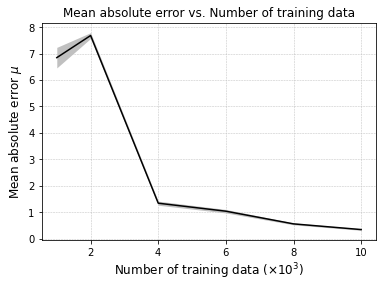

In [13]:
from matplotlib import pyplot as pl
import numpy as np

pl.clf()

x = Tdata_len
y = MAE[0]
error = MAE[1]
print(np.array(y)-np.array(error))
pl.plot(x, y, 'k', color='black')
pl.fill_between(x, (np.array(y)-np.array(error)), (np.array(y)+np.array(error)),
    alpha=1, edgecolor='black', facecolor='silver',
    linewidth=0)

plt.xlabel(r'Number of training data $ (\times 10^{3})$', fontsize=12)
plt.ylabel(r'Mean absolute error $\mu$', fontsize=12)

plt.title('Mean absolute error vs. Number of training data', fontsize=12)
plt.grid(which='major', linestyle='--', linewidth='0.5', color='silver')

label_size = 10
pl.rcParams['xtick.labelsize'] = label_size 
pl.rcParams['ytick.labelsize'] = label_size 

plt.savefig('TD_len.png')
pl.show()